## **Predicción de acciones en la bolsa con Python y Keras (Redes LSTM)**
Veremos cómo implementar, paso a paso, una Red LSTM que permita predecir el valor que tendrá en el futuro una acción en la bolsa de valores.

En particular lo que haremos será visualizar el comportamiento histórico de la acción de Apple en los últimos años, y vamos a diseñar y entrenar una en Python y Keras, la cual tomará estos datos históricos y permitirá generar una predicción.

## **Introducción**
Recordemos que una Red LSTM es un tipo de Red Neuronal Recurrente que permite analizar secuencias (como texto, conversaciones, o precisamente el comportamiento histórico de una acción en la bolsa) y que además tiene una memoria de largo plazo.
En esta práctica veremos en detalle cómo implementar una Red LSTM en Python, usando específicamente la librería Keras.

### Importación de librerias

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### Funciones auxiliares

In [2]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

### El set de datos
Este set de dato contiene el registro histórico del comportamiento de la acción de Apple entre enero de 2006 y diciembre de 2017.

Este set lo podemos leer fácilmente usando la librería Pandas de Python:

In [3]:
dataset = pd.read_csv('14_AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Al visualizar el contenido de este dataset podemos observar que cada registro contiene la información de los valores más altos y más bajos alcanzados por la acción, así como los valores de apertura y cierre y el volumen de las transacciones.

En esta práctica entrenaremos la Red LSTM usando únicamente el valor más alto de la acción (columna High en el set de datos).

## **Pre-procesamiento de los datos**

### Creación de los sets de entrenamiento y validación
Para el entrenamiento de la Red LSTM usaremos los datos entre Enero de 2006 y Diciembre de 2016, mientras que para la validación y la predicción usaremos todos los registros del año 2017.

La idea es que la Red LSTM aprenda a predecir los valores máximos de la acción para el año 2017, usando el comportamiento en años anteriores:
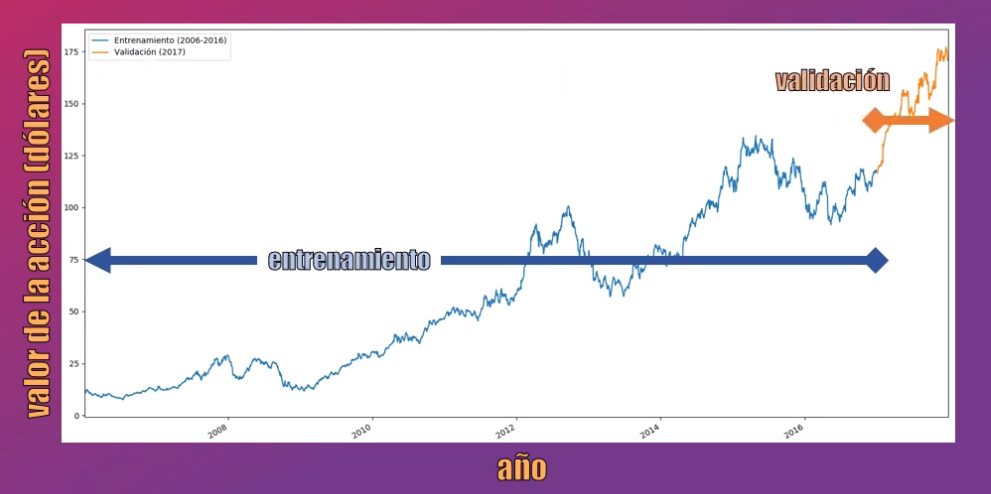

Teniendo esto en cuenta, podemos crear los sets de entrenamiento y validación usando la función iloc de Pandas:

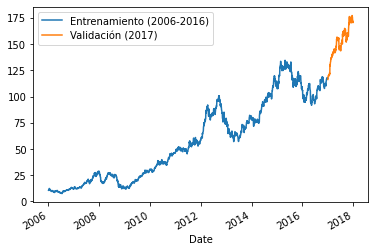

In [4]:
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

en donde .iloc[:,1:2] nos permite seleccionar únicamente la columna High del dataset.

## Normalización de los datos
Si analizamos el comportamiento de la acción de Apple en los últimos años veremos que tiene una tendencia creciente.

Para que la Red LSTM pueda ser entrenada que los valores de la acción se encuentran en un rango definido. Así que vamos a usar la librería Scikit-learn para normalizar estos valores en el rango de 0 a 1, usando la función MinMaxScaler:

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

Y una vez hecho el entrenamiento, al momento de la predicción, realizaremos la transformación inversa para obtener los valores en la escala real.

## Ajuste de los sets de entrenamiento y validación
Para entrenar la Red LSTM tomaremos bloques de 60 datos consecutivos, y la idea es que cada uno de estos permita predecir el siguiente valor:

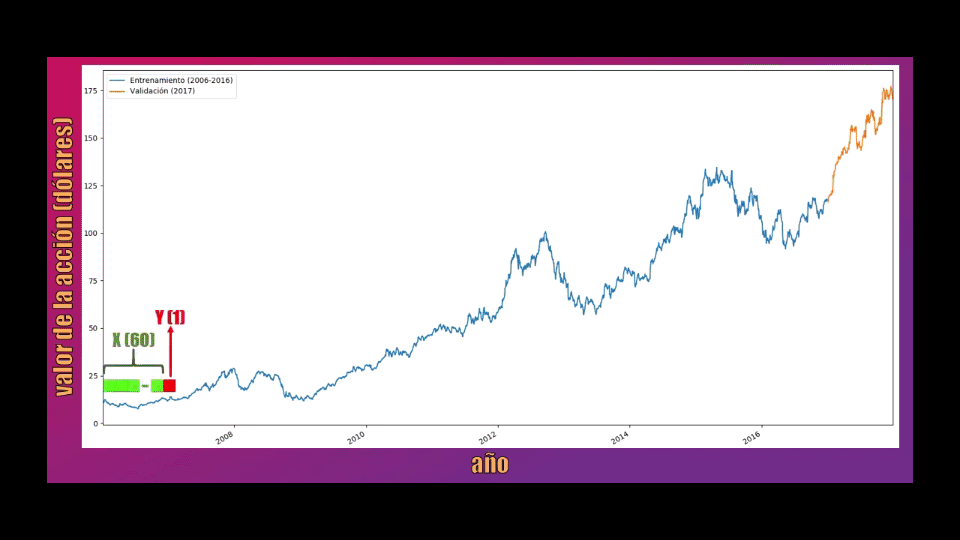

Los bloques de 60 datos serán almacenados en la variable X, mientras que el dato que se debe predecir (el dato 61 dentro de cada secuencia) se almacenará en la variable Y y será usado como la salida de la Red LSTM:

In [6]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

En el código anterior usamos el bloque for para iterativamente dividir el set de entrenamiento en bloques de 60 datos y almacenar los bloques correspondientes en diferentes posiciones de las variables X_train y Y_train.

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de 60x1. Para esto usamos la función reshape de Numpy:

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## **Creación y entrenamiento de la Red LSTM**

### Implementación del modelo en Keras
Para implementar el modelo debemos primero importar las librerías de Keras correspondientes a las Redes LSTM. Usaremos el módulo Sequential para crear el contenedor, al cual iremos añadiendo la Red LSTM (usando el módulo LSTM) y la capa de salida (usando el módulo Dense):

Para crear la red debemos primero definir el tamaño de los datos de entrada y del dato de salida, así como el número total de neuronas (50):

In [7]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

Como lo mencionamos anteriormente, para crear la Red LSTM debemos primero crear un contenedor usando el módulo Sequential:

In [8]:
modelo = Sequential()

Ahora añadimos la Red LSTM usando la función add, especificando el número de neuronas a usar (parámetro units) y el tamaño de cada dato de entrada (parámetro input_shape):

In [9]:
modelo.add(LSTM(units=na, input_shape=dim_entrada))

Para la capa de salida usamos la función Dense y especificamos que el dato de salida tendrá un tamaño igual a 1 (parámetro units):

In [10]:
modelo.add(Dense(units=dim_salida))

Ahora debemos compilar el modelo, definiendo así la función de error (parámetro loss) así como el método que se usará para minimizarla (parámetro optimizer):

In [11]:
modelo.compile(optimizer='rmsprop', loss='mse')

El optimizador seleccionado (rmsprop) funciona de manera similar al algoritmo del Gradiente Descendente, mientras que la función de error es el error cuadrático medio, el cual explico en detalle en el artículo acerca de la Regresión Lineal.

El entrenamiento se implementa de forma sencilla usando la función fit. En este caso usaremos un total de 20 iteraciones (parámetro epochs) y presentaremos a la Red LSTM lotes de 32 datos (parámetro batch_size):

In [12]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 6s 30ms/step - loss: 0.0151
Epoch 2/20
85/85 [==============================] - 3s 33ms/step - loss: 0.0015
Epoch 3/20
85/85 [==============================] - 3s 31ms/step - loss: 8.4923e-04
Epoch 4/20
85/85 [==============================] - 3s 31ms/step - loss: 6.1648e-04
Epoch 5/20
85/85 [==============================] - 3s 32ms/step - loss: 5.0913e-04
Epoch 6/20
85/85 [==============================] - 3s 33ms/step - loss: 3.7658e-04
Epoch 7/20
85/85 [==============================] - 3s 32ms/step - loss: 3.6869e-04
Epoch 8/20
85/85 [==============================] - 2s 29ms/step - loss: 3.2282e-04
Epoch 9/20
85/85 [==============================] - 3s 31ms/step - loss: 2.9142e-04
Epoch 10/20
85/85 [==============================] - 3s 30ms/step - loss: 2.6004e-04
Epoch 11/20
85/85 [==============================] - 2s 29ms/step - loss: 2.5477e-04
Epoch 12/20
85/85 [==============================] - 2s 29ms/step - loss: 2.4388e-

## **Predicción del valor de la acción**
Con el modelo entrenado, veamos qué tan bien predice esta Red LSTM los valores de la acción de Apple.

Inicialmente debemos preparar el set de validación, normalizando inicialmente los datos, en el rango de 0 a 1, para lo cual usamos la transformación implementada anteriormente sobre el set de entrenamiento:

In [13]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


Recordemos que el modelo fue entrenado para tomar 60 y generar un dato como predicción. Así que debemos reorganizar el set de validación (x_test) para que tenga bloques de 60 datos:

In [14]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


Y finalmente realizamos la predicción usando la función predict y aplicamos la normalización inversa de dicha predicción para que esté en la escala real de las acciones:

In [15]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


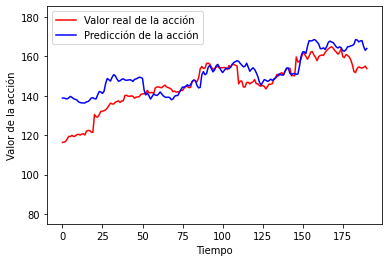

In [16]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

Al ejecutar este código vemos que la red logra predecir bastante bien los valores máximos de la acción de Apple, pues para la mayor parte de los datos predichos la diferencia es igual o menor a los 10 dólares con respecto al valor real:

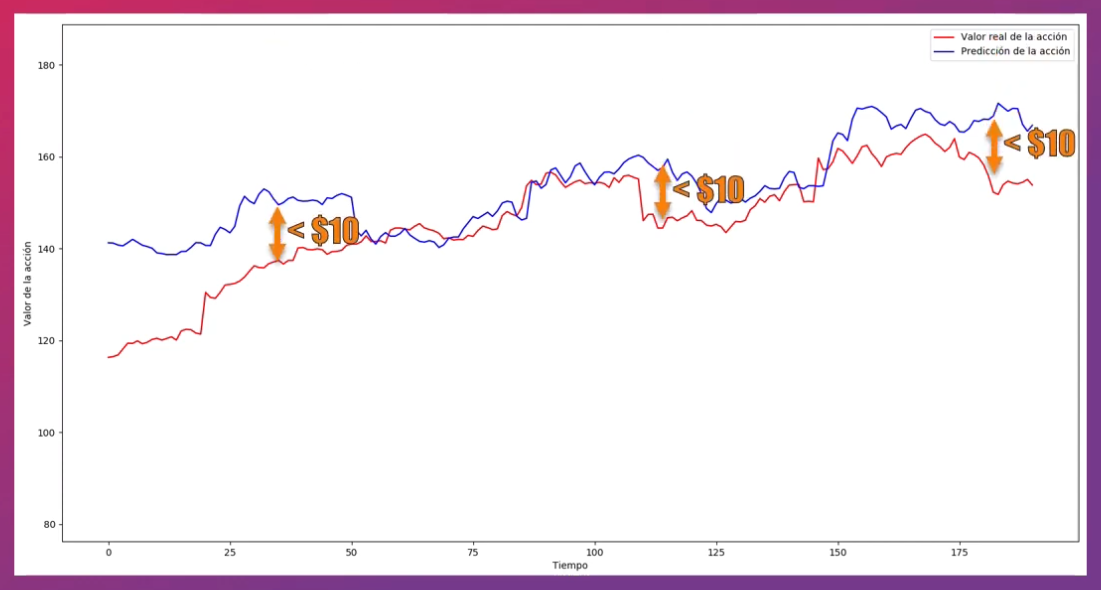